In [1]:
import numpy as np
from EmbedSeg.utils.create_dicts import create_test_configs_dict
from EmbedSeg.test import begin_evaluating
from glob import glob
import tifffile
import matplotlib.pyplot as plt
from EmbedSeg.utils.visualize import visualize
from EmbedSeg.train import invert_one_hot
import os
from matplotlib.colors import ListedColormap
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import json

### Specify the path to the evaluation images

In [2]:
data_dir = '../../../data'
project_name = 'usiigaci-2017'
print("Evaluation images shall be read from: {}".format(os.path.join(data_dir, project_name)))

Evaluation images shall be read from: ../../../data/usiigaci-2017


### Specify evaluation parameters 

Some hints:
* `tta`: Setting this to True (default) would enable **test-time augmentation**
* `ap_val`: This parameter ("average precision value") comes into action if ground truth segmentations exist for evaluation images, and allows to compare how good our predictions are versus the available ground truth segmentations.
* `seed_thresh`: This parameter ("seediness threshold") allows considering only those pixels as potential instance-centres which have a seediness score greater than `seed_thresh`
* `checkpoint_path`: This parameter provides the path to the trained model weights which you would like to use for evaluation. One could test the pretrained model (available at `'../../../pretrained_models/bbbc010-2012/best_iou_model.pth'`) to get a quick glimpse on the results.
* `save_dir`: This parameter specifies the path to the prediction instances. Equal to `static` by default.
* `save_images`: If True, this saves predictions at `./static/predictions/` 
* `save_results`: If True, this saves results at `./static/results/`

In the cell after this one, a `test_configs` dictionary is generated from the parameters specified here!
<a id='checkpoint'></a>

In [3]:
# uncomment for the model trained by you
# checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')
# if os.path.isfile('data_properties.json'): 
#     with open('data_properties.json') as json_file:
#         data = json.load(json_file)
#         one_hot, data_type, min_object_size, n_y, n_x = data['one_hot'], data['data_type'], int(data['min_object_size']), int(data['n_y']), int(data['n_x'])

# use the following for the pretrained model weights
checkpoint_path = os.path.join('../../../pretrained_models', project_name, 'best_iou_model.pth')
if os.path.isfile(os.path.join('../../../pretrained_models', project_name,'data_properties.json')): 
    with open(os.path.join('../../../pretrained_models', project_name, 'data_properties.json')) as json_file:
        data = json.load(json_file)
        one_hot, data_type, min_object_size, n_y, n_x = data['one_hot'], data['data_type'], int(data['min_object_size']), int(data['n_y']), int(data['n_x'])

In [4]:
tta = True
ap_val = 0.5
seed_thresh = 0.90
save_dir = './static'
save_images = True
save_results = True
normalization_factor = 65535 if data_type=='16-bit' else 255

In [5]:
if os.path.exists(checkpoint_path):
    print("Trained model weights found at : {}".format(checkpoint_path))
else:
    print("Trained model weights were not found at the specified location!")

Trained model weights found at : ../../../pretrained_models/usiigaci-2017/best_iou_model.pth


### Create `test_configs` dictionary from the above-specified parameters

In [6]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        ap_val = ap_val,
                                        seed_thresh = seed_thresh, 
                                        min_object_size = min_object_size, 
                                        save_images = save_images,
                                        save_results = save_results,
                                        save_dir = save_dir,
                                        normalization_factor = normalization_factor,
                                        one_hot = one_hot,
                                        n_y = n_y,
                                        n_x = n_x,
                                        )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../../data/usiigaci-2017, 
 -- trained weights accessed from ../../../pretrained_models/usiigaci-2017/best_iou_model.pth, 
 -- seediness threshold set at 0.9, 
 -- output directory chosen as ./static


### Begin Evaluating

Setting `verbose` to True shows you Average Precision at IOU threshold specified by `ap_val` above for each individual image. The higher this score is, the better the network has learnt to perform instance segmentation on these unseen images.

In [7]:
%matplotlib agg
begin_evaluating(test_configs, verbose = False)

2-D `test` dataloader created! Accessing data from ../../../data/usiigaci-2017/test/
Number of images in `test` directory is 5
Number of instances in `test` directory is 5
Number of center images in `test` directory is 0
*************************
Creating branched erfnet with [4, 1] classes


100%|██████████| 5/5 [00:24<00:00,  4.89s/it]

Mean Average Precision at IOU threshold = 0.5, is equal to 0.72506


<div class="alert alert-block alert-warning"> 
  Common causes for a low score/error is: <br>
    1. Accessing the model weights at the wrong location (this could happen, for example, if you access the prediction on a day different from the one when you trained the notebook). Simply editing the <b> checkpoint_path</b> would fix the issue. <br>
    2. At times, you would notice an improved performance by lowering <b><a href="#checkpoint"> seed_thresh</a></b> from 0.90 (default) to say 0.80. <br>
    3. CUDA error: out of memory - ensure that you shutdown <i>02-train.ipynb</i> notebook before running this notebook.
</div>

<div class="alert alert-block alert-info"> 
The complete set of runs for different partitions of the data is available <b><a href = "https://github.com/juglab/EmbedSeg/wiki/Usiigaci_2017"> here </a></b>!
</div>   

### Load a glasbey-style color map

In [8]:
new_cmp= np.load('../../../cmaps/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

### Investigate some qualitative results

Here you can investigate some quantitative predictions. GT segmentations and predictions, if they exist, are loaded from sub-directories under `save_dir`.
Simply change `index` in the next two cells, to show the prediction for a random index.
Going clockwise from top-left is 

    * the raw-image which needs to be segmented, 
    * the corresponding ground truth instance mask, 
    * the network predicted instance mask, and 
    * (if display_embedding = True) from each object instance, 5 pixels are randomly selected (indicated with `+`), their embeddings are plotted (indicated with `.`) and the predicted margin for that object is visualized as an axis-aligned ellipse centred on the predicted - center (indicated with `x`)  for that object

In [9]:
%matplotlib inline
if(save_images):
    prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
    ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
    embedding_file_names = sorted(glob(os.path.join(save_dir,'embedding','*.tif')))
    image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))

Image filename is 47.tif and index is 1


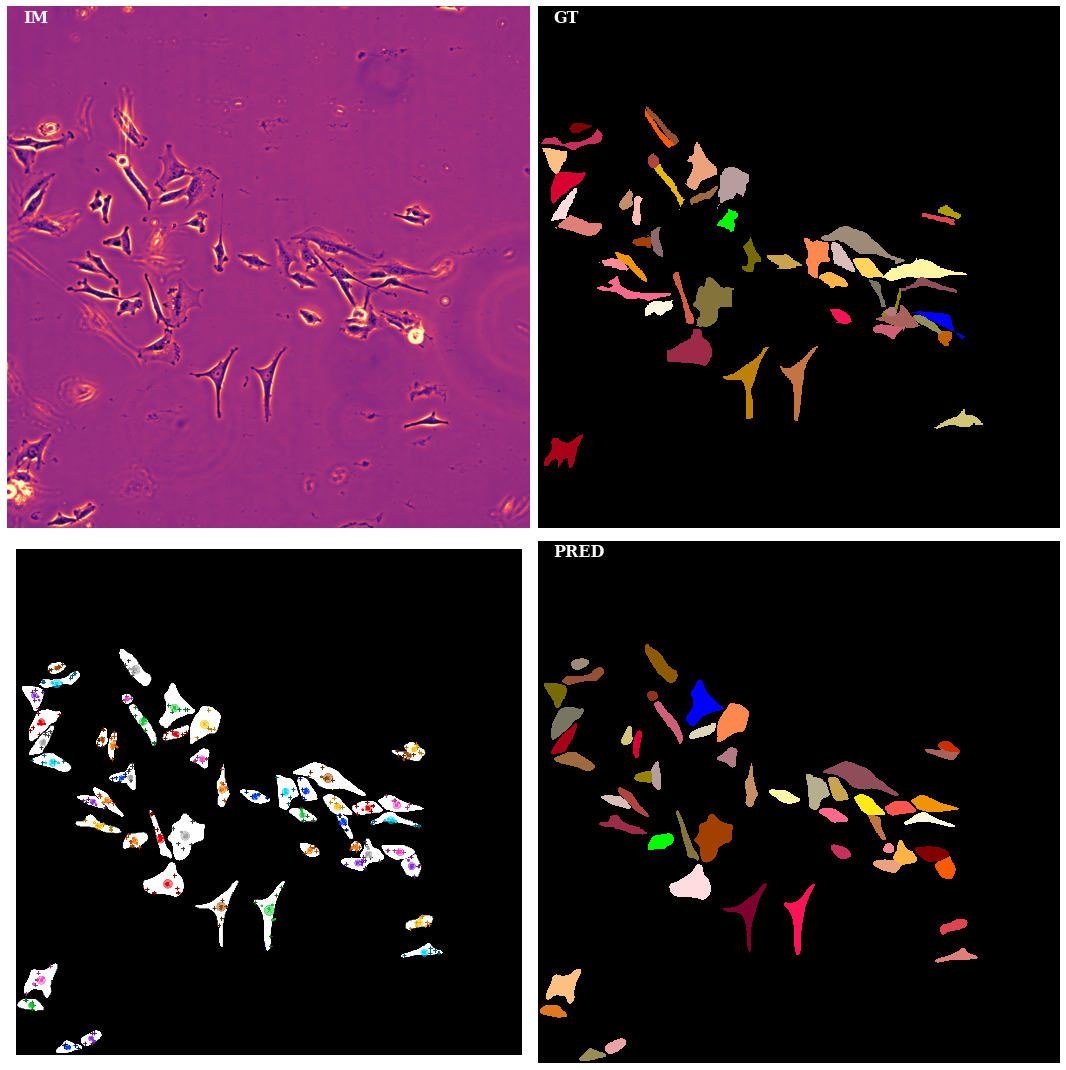

In [10]:
if(save_images):
    index = 1 
    print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
    prediction = tifffile.imread(prediction_file_names[index])
    image = tifffile.imread(image_file_names[index])
    embedding = tifffile.imread(embedding_file_names[index])
    if len(ground_truth_file_names) > 0:
        ground_truth = tifffile.imread(ground_truth_file_names[index])
        visualize(image = image, prediction = prediction, ground_truth = ground_truth, embedding = embedding, new_cmp = new_cmp)
    else:
        visualize(image = image, prediction = prediction, ground_truth = None, embedding = embedding, new_cmp = new_cmp)

Image filename is 49.tif and index is 3


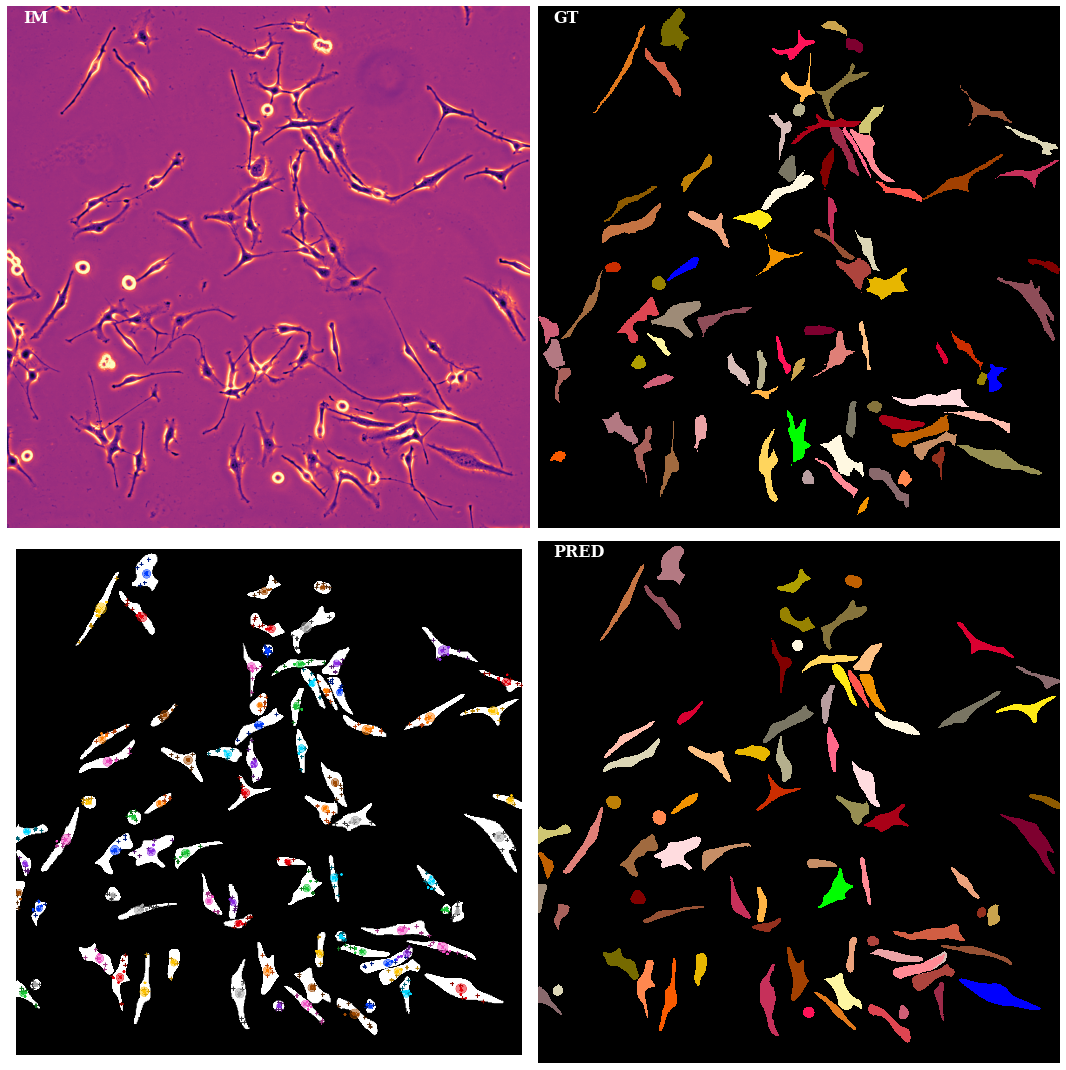

In [11]:
if (save_images):
    index = 3
    print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
    prediction = tifffile.imread(prediction_file_names[index])
    image = tifffile.imread(image_file_names[index])
    embedding = tifffile.imread(embedding_file_names[index])
    if len(ground_truth_file_names) > 0:
        ground_truth = tifffile.imread(ground_truth_file_names[index])
        visualize(image = image, prediction = prediction, ground_truth = ground_truth, embedding = embedding, new_cmp = new_cmp)
    else:
        visualize(image = image, prediction = prediction, ground_truth = None, embedding = embedding, new_cmp = new_cmp)